In [41]:
import numpy as np
from numpy.random import uniform
import matplotlib.pyplot as plt
import pandas as pd
from scipy.interpolate import interp1d
from scipy.interpolate import UnivariateSpline
import sympy as smp
from scipy.stats import rv_continuous
plt.style.use(['science', 'notebook'])
from functions import *
import functions as f
import matplotlib
import scipy.ndimage as ndimage
from skimage.transform import rotate

Data

In [2]:
'''Attenuation coefficient data'''
df = pd.read_csv('water_data.txt', sep=' ', dtype=np.float32)
energy_d = df['Energy(MeV)'].values
coherent_d = df['Coherent(cm^2g^-1)'].values
compton_d = df['Compton(cm^2g^-1)'].values
photo_d = df['Photoelectric(cm^2g^-1)'].values
pairtrip_d = df['Pair+Triplet(cm^2g^-1)'].values
Etrans_d = df['Energy-Transfer(cm^2g^-1)'].values
Eabs_d = df['Energy-Absorption(cm^2g^-1)'].values
brem_d = df['1-g'].values
mu_d = coherent_d + compton_d+photo_d + pairtrip_d
mutr_d = df['Energy-Transfer(cm^2g^-1)'].values

# Problem 1

## Part A

Create radiation simulation object for photons emitted isotropically from point source.

In [2]:
N = 1000000
E0 = 50
E = E0*np.ones(N)
X = np.zeros((3,N))
Phi0 = 2*np.pi*uniform(size=N)
Theta0 = np.arccos(1-2*uniform(size=N))
Ang = np.array([Phi0, Theta0])
Ebins = 10.0**(np.linspace(-3,np.log10(E0), 100))
int_types = np.arange(4)
r = RadSim(E, X, Ang, Ebins, int_types)

Run simultion

In [3]:
while True:
    if r.iterate():
        break

Open up relative probability of different interactions at different energies

* From simulation
* Theoretically from attenuation coefficients

In [42]:
'''From simulation'''
int_total_per_energy = r.IntHist_p.sum(axis=0)
a1, a2, a3, a4 = r.IntHist_p / int_total_per_energy 

Plot

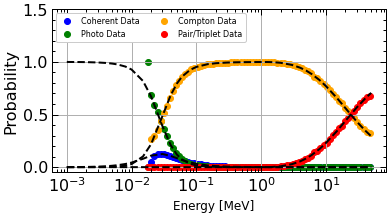

In [168]:
fig, ax = plt.subplots(1, 1, figsize=(6,3))
ax.plot(energy_d, coherent_d/mu_d, color='k', ls='--')
ax.plot(energy_d, photo_d/mu_d, color='k', ls='--')
ax.plot(energy_d, compton_d/mu_d, color='k', ls='--')
ax.plot(energy_d, pairtrip_d/mu_d, color='k', ls='--')
ax.semilogx()
ax.set_ylim(top=1.5)
ax.set_ylabel('Probability')
fig.suptitle('Energy [MeV]', y=0)
plt.scatter(Ebins[0:-1] + np.diff(Ebins)/2, a1, color='b', label=r'Coherent Data')
plt.scatter(Ebins[0:-1] + np.diff(Ebins)/2, a2, color='g', label=r'Photo Data')
plt.scatter(Ebins[0:-1] + np.diff(Ebins)/2, a3, color='orange', label=r'Compton Data')
plt.scatter(Ebins[0:-1] + np.diff(Ebins)/2, a4, color='red', label=r'Pair/Triplet Data')
ax.legend(fontsize=8, ncol=2, facecolor='white', framealpha=1, frameon=True, loc='upper left')
plt.grid()
plt.savefig('images/q1.png', dpi=200)
plt.show()

## Part B

Get analytical formula

In [6]:
E, alpha, T, theta = smp.symbols(r'E \alpha T \theta', real=True, positive=True)
T_expr = E*alpha*(1-smp.cos(theta))/(1+alpha*(1-smp.cos(theta)))
theta_expr = smp.solve(T-T_expr, theta)[1]
dsdo_expr = smp.Rational(1,2)*(1+smp.cos(theta)**2)/(1+alpha*(1-smp.cos(theta)))**2 * \
            ( 1 + alpha**2 * (1-smp.cos(theta))**2 / ((1+smp.cos(theta)**2)*(1+alpha*(1-smp.cos(theta)))))
dsdT = 2*smp.pi*smp.sin(theta) * dsdo_expr / smp.diff(T_expr, theta)
dsdT = dsdT.subs(theta, theta_expr).simplify()
Tmin = 0 
Tmax = 2*E*alpha/(1+2*alpha)
sigma_check = smp.integrate(dsdT, (T, Tmin, Tmax)).expand().simplify().simplify()
pdf = dsdT / sigma_check
avgT = smp.integrate(pdf*(T/E), (T, Tmin, Tmax)).simplify().simplify()
avgT_f = smp.lambdify(alpha, avgT)

In [7]:
avgT

(-20*\alpha**5 + 102*\alpha**4 + 186*\alpha**3 + 102*\alpha**2 + 18*\alpha + (24*\alpha**5 - 12*\alpha**4 - 126*\alpha**3 - 141*\alpha**2 - 60*\alpha - 9)*log(2*\alpha + 1))/(3*(4*\alpha**5 + 38*\alpha**4 + 50*\alpha**3 + 24*\alpha**2 + 4*\alpha + (8*\alpha**5 - 4*\alpha**4 - 34*\alpha**3 - 35*\alpha**2 - 14*\alpha - 2)*log(2*\alpha + 1)))

In [8]:
print(smp.latex(avgT))

\frac{- 20 \alpha^{5} + 102 \alpha^{4} + 186 \alpha^{3} + 102 \alpha^{2} + 18 \alpha + \left(24 \alpha^{5} - 12 \alpha^{4} - 126 \alpha^{3} - 141 \alpha^{2} - 60 \alpha - 9\right) \log{\left(2 \alpha + 1 \right)}}{3 \left(4 \alpha^{5} + 38 \alpha^{4} + 50 \alpha^{3} + 24 \alpha^{2} + 4 \alpha + \left(8 \alpha^{5} - 4 \alpha^{4} - 34 \alpha^{3} - 35 \alpha^{2} - 14 \alpha - 2\right) \log{\left(2 \alpha + 1 \right)}\right)}


In [9]:
energy_arr = np.linspace(0.01, 50, 10000) 
avgT_arr = avgT_f(energy_arr/0.511)

Get compton angles from simulation

In [10]:
ratios, bins = np.histogram(r.comptonenergies, Ebins, weights=r.comptonratios)
total, bins = np.histogram(r.comptonenergies, Ebins)
T = ratios/total
Ep = bins[:-1] + np.diff(bins)/2

<ipython-input-10-1903f69e0dfa>:3: RuntimeWarning: invalid value encountered in true_divide
  T = ratios/total


Plot

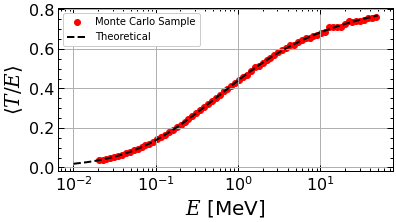

In [11]:
plt.figure(figsize=(6,3))
plt.scatter(Ep, T, color='r', label='Monte Carlo Sample')
plt.plot(energy_arr, avgT_arr, color='k', ls='--', label='Theoretical')
plt.xlabel('$E$ [MeV]', fontsize=20)
plt.ylabel(r'$\left<T/E\right>$', fontsize=20)
plt.grid()
plt.legend(fontsize=10, facecolor='white', framealpha=1, frameon=True, loc='upper left')
plt.semilogx()
plt.savefig('images/q2.png', dpi=200)
plt.show()

## Part C

In [12]:
avg_inters = []
for E0 in energy_d:
    N = 5000
    E = E0*np.ones(N)
    X = np.zeros((3,N))
    Phi0 = 2*np.pi*uniform(size=N)
    Theta0 = np.arccos(1-2*uniform(size=N))
    Ang = np.array([Phi0, Theta0])
    Ebins = 10.0**(np.linspace(-3,np.log10(E0), 100))
    int_types = np.arange(4)
    ri = RadSim(E, X, Ang, Ebins, int_types)
    while True:
        if ri.iterate():
            break
    avg_inters.append(len(ri.E_e)/N)
avg_inters = np.array(avg_inters)

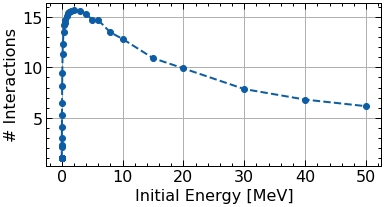

In [13]:
plt.figure(figsize=(6,3))
plt.plot(energy_d, avg_inters, 'o--')
plt.xlabel('Initial Energy [MeV]')
plt.ylabel('# Interactions')
plt.grid()
plt.savefig('images/q3.png', dpi=200)
plt.show()

## Part D

Get $d\sigma/d\theta$ as a numerical function

In [150]:
dsdt = 2*smp.pi*dsdo_expr*smp.sin(theta)
dsdt = dsdt.simplify()
dsdt_f = smp.lambdify([alpha, theta], dsdt)

Get number of particles at different energies

In [151]:
theta_num = np.linspace(0, np.pi, 100)
N_CE, E_CE = np.histogram(r.comptonenergies, bins=1000)
E_CE = E_CE[1:] - np.diff(E_CE)[0]/2

To get pdf over a spectrum of energies:

$$f(\theta) = \frac{\int_E f(\theta, E) dN(E)}{\int_E dN(E)}$$

In [164]:
def compute_rest_theory():
    b = dsdt_f(*np.meshgrid(E_CE/0.511, theta_num))
    b = b/np.sum(b, axis=0)
    rest_theory = np.sum(b *N_CE, axis=1)
    rest_theory = rest_theory / sum(rest_theory * np.diff(theta_num)[0])
    return rest_theory

In [165]:
rest_theory = compute_rest_theory()

Note: there should be no preferred direction

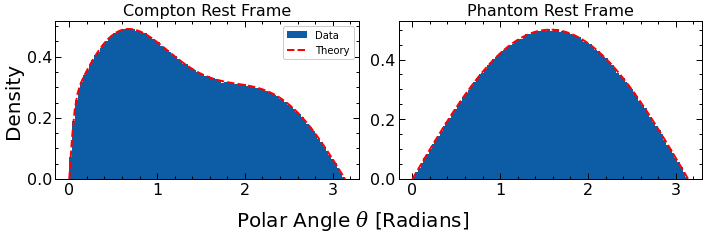

In [169]:
fig, ax = plt.subplots(figsize=(10,3))
plt.subplot(121)
plt.hist(r.comptonthetas, bins=100, density=True, label='Data')
plt.plot(theta_num, rest_theory, color='r', ls='--', lw=2, label='Theory')
plt.title('Compton Rest Frame')
plt.ylabel('Density', fontsize=20)
plt.legend(fontsize=10, facecolor='white', framealpha=1, frameon=True, loc='upper right')
plt.subplot(122)
plt.hist(r.comptonthetas_rest, bins=100, density=True, label='Monte Carlo')
plt.plot(theta_num, 0.5*np.sin(theta_num), color='r', ls='--', lw=2)
plt.title('Phantom Rest Frame')
fig.tight_layout()
fig.suptitle(r'Polar Angle $\theta$ [Radians]',x=0.5,y=0, ha='center', fontsize=20)
plt.savefig('images/q4.png', dpi=200)
plt.show()

# Problem 2

**Ignore these cells if already ran once: they are to generate histograms**

In [16]:
# Run this or the cell below
N = 10000000
E = get_6MV_spectrum(N)
R = np.sqrt(2) * np.sqrt(np.log(6/E))
phi = 2*np.pi*np.random.uniform(size=N)
x = R*np.cos(phi)+(1e-19) * np.random.randn(len(R))
y = R*np.sin(phi)+(1e-19) * np.random.randn(len(R))
z=np.zeros(N)
X = np.array([x, y, z])
theta = np.arctan(R/100)
Ang = np.array([phi, theta])
Ebins = 10.0**(np.linspace(-3,1,100))
int_types = np.arange(4)
r = RadSim(E, X, Ang, Ebins, int_types, XYZ_lim=[15.,15.,0.,50.])

In [17]:
while True:
    if r.iterate():
        break

In [18]:
voxel = 0.25
binsx = np.arange(-15.25,15.75,voxel)
binsy = np.arange(-15.25,15.75,voxel)
binsz = np.arange(0,50.5,voxel)
tot_hist, kerma_hist, dose_hist = r.compute_volume_hists(binsx, binsy, binsz, dEdx=2)

In [26]:
np.save('sample_data/tot_hist', tot_hist)
np.save('sample_data/kerma_hist', kerma_hist)
np.save('sample_data/dose_hist', dose_hist)

**Run the cell below to open already saved data**

In [72]:
tot_hist = np.load('sample_data/tot_hist.npy')
kerma_hist = np.load('sample_data/kerma_hist.npy')
dose_hist = np.load('sample_data/dose_hist.npy')
voxel = 0.25
binsx = np.arange(-15.25,15.75,voxel)
binsy = np.arange(-15.25,15.75,voxel)
binsz = np.arange(0,50.5,voxel)
N = 10000000

In [73]:
mid_xy = kerma_hist.shape[0]//2

In [74]:
x = binsx[1:] - np.diff(binsx)[0]/2
y = binsy[1:] - np.diff(binsy)[0]/2
xv, yv = np.meshgrid(x,y)

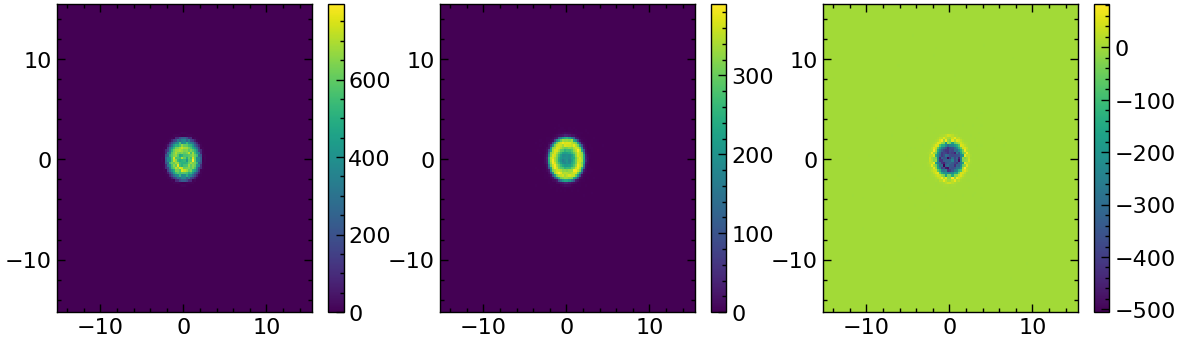

In [75]:
slc = 0
plt.figure(figsize=(14,4))
plt.subplot(131)
plt.pcolormesh(xv, yv, kerma_hist[:,:,slc])
plt.colorbar()
plt.subplot(132)
plt.pcolormesh(xv, yv, dose_hist[:,:,slc])
plt.colorbar()
plt.subplot(133)
plt.pcolormesh(xv, yv, dose_hist[:,:,slc] - kerma_hist[:,:,slc])
plt.colorbar()
plt.show()

In [76]:
z = binsz[1:] -np.diff(binsz)/2
MV_to_J = 1.60218e-13
J_to_GY =  1 / (1 * voxel**3 / 1000) #1/(rho * volume)
f = MV_to_J * J_to_GY

oc = xv**2 + yv**2 <= 1**2
oc_bool = np.tile(oc, (kerma_hist.shape[-1],1,1)).astype(int)
CF = len(oc_bool[0].ravel()) / np.sum(oc_bool[0])
kerma_center = np.mean(kerma_hist*oc_bool.T, axis=(0,1))* CF *f /N
dose_center = np.mean(dose_hist*oc_bool.T, axis=(0,1))* CF* f /N

oc = xv**2 + yv**2 >= 1**2
oc_bool = np.tile(oc, (kerma_hist.shape[-1],1,1)).astype(int)
CF = len(oc_bool[0].ravel()) / np.sum(oc_bool[0])
kerma_outer = np.mean(kerma_hist*oc_bool.T, axis=(0,1))* CF *f /N
dose_outer = np.mean(dose_hist*oc_bool.T, axis=(0,1))* CF *f /N

kerma_tot = np.mean(kerma_hist, axis=(0,1))* f /N
dose_tot = np.mean(dose_hist, axis=(0,1))* f /N

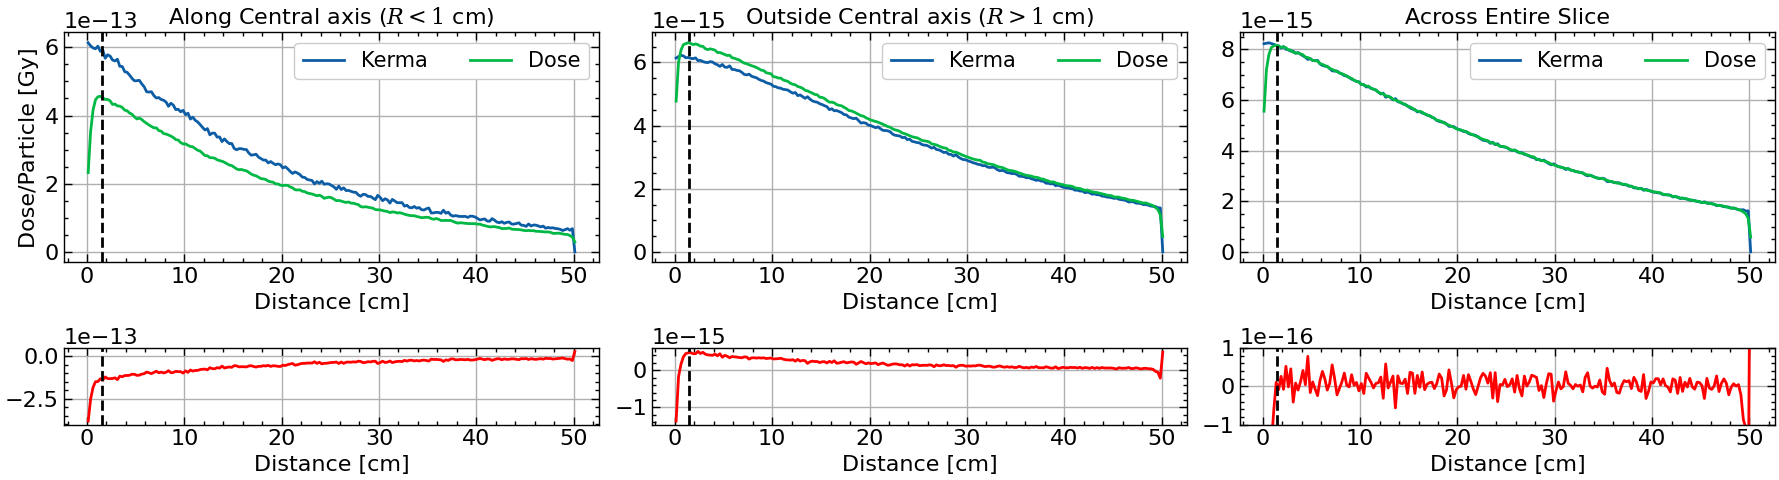

In [77]:
fig, ax = plt.subplots(2,3, figsize=(18,5), gridspec_kw={'height_ratios': [3, 1]})
plt.subplot(231)
plt.title('Along Central axis ($R<1$ cm)')
plt.plot(z, kerma_center, label='Kerma')
plt.plot(z, dose_center, label='Dose')
plt.axvline(1.5, color='k', ls='--')
plt.grid()
plt.legend(ncol=2, fontsize=15, facecolor='white', framealpha=1, frameon=True, loc='upper right')
plt.xlabel('Distance [cm]')
plt.ylabel('Dose/Particle [Gy]')
plt.subplot(234)
plt.plot(z, dose_center-kerma_center, label='Kerma', color='r')
plt.axvline(1.5, color='k', ls='--')
plt.grid()
plt.xlabel('Distance [cm]')
plt.subplot(232)
plt.title('Outside Central axis ($R>1$ cm)')
plt.plot(z, kerma_outer, label='Kerma')
plt.plot(z, dose_outer, label='Dose')
plt.axvline(1.5, color='k', ls='--')
plt.grid()
plt.legend(ncol=2, fontsize=15, facecolor='white', framealpha=1, frameon=True, loc='upper right')
plt.xlabel('Distance [cm]')
plt.subplot(235)
plt.plot(z, dose_outer-kerma_outer, label='Kerma', color='r')
plt.axvline(1.5, color='k', ls='--')
plt.grid()
plt.xlabel('Distance [cm]')
plt.subplot(233)
plt.title('Across Entire Slice')
plt.plot(z, kerma_tot, label='Kerma')
plt.plot(z, dose_tot, label='Dose')
plt.axvline(1.5, color='k', ls='--')
plt.grid()
plt.legend(ncol=2, fontsize=15, facecolor='white', framealpha=1, frameon=True, loc='upper right')
plt.xlabel('Distance [cm]')
plt.subplot(236)
plt.plot(z, dose_tot-kerma_tot, label='Kerma', color='r')
plt.ylim(bottom=-1e-16, top=1e-16)
plt.axvline(1.5, color='k', ls='--')
plt.grid()
plt.xlabel('Distance [cm]')
fig.tight_layout()
plt.savefig('images/dosekerma.png', dpi=200)
plt.show()

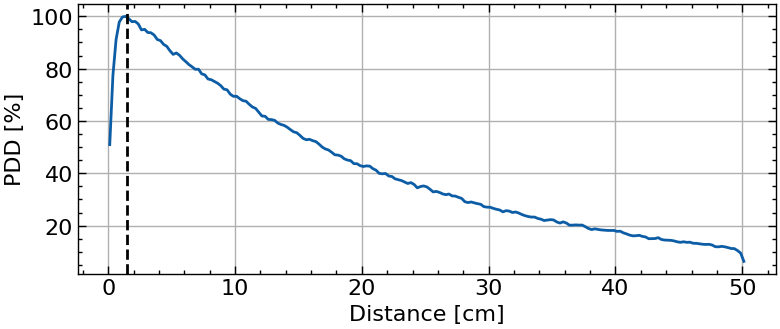

In [78]:
plt.figure(figsize=(9,3.5))
plt.subplot(111)
plt.plot(z, dose_center/max(dose_center) * 100, label='Dose')
plt.axvline(1.5, color='k', ls='--')
plt.grid()
plt.xlabel('Distance [cm]')
plt.ylabel('PDD [%]')
plt.savefig('images/p5.png', dpi=200)
plt.show()

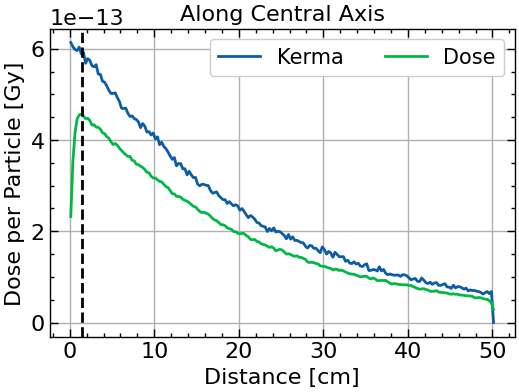

In [79]:
plt.figure(figsize=(6,4))
plt.subplot(111)
plt.title('Along Central Axis')
plt.plot(z, kerma_center, label='Kerma')
plt.plot(z, dose_center, label='Dose')
plt.axvline(1.5, color='k', ls='--')
plt.grid()
plt.legend(ncol=2, fontsize=15, facecolor='white', framealpha=1, frameon=True, loc='upper right')
plt.xlabel('Distance [cm]')
plt.ylabel('Dose per Particle [Gy]')
plt.savefig('dosekerma.png', dpi=200)
plt.show()

In [80]:
d = x
cross_x_1 = (dose_hist[:,mid_xy,z-voxel/2 == 1.5] + dose_hist[:,mid_xy,z+voxel/2 == 1.5])/2  * f / N 
cross_x_5 = (dose_hist[:,mid_xy,z-voxel/2 == 5] + dose_hist[:,mid_xy,z+voxel/2 == 5])/2* f / N 
cross_x_10 = (dose_hist[:,mid_xy,z-voxel/2 == 10] + dose_hist[:,mid_xy,z+voxel/2 == 10])/2 * f / N 
cross_x_20 = (dose_hist[:,mid_xy,z-voxel/2 == 20] + dose_hist[:,mid_xy,z+voxel/2 == 20])/2 * f / N 
cross_y_1 = (dose_hist[mid_xy,:,z-voxel/2 == 1.5] + dose_hist[mid_xy,:,z+voxel/2 == 1.5])/2 * f / N 
cross_y_5 = (dose_hist[mid_xy,:,z-voxel/2 == 5] + dose_hist[mid_xy,:,z+voxel/2 == 5])/2 * f / N 
cross_y_10 = (dose_hist[mid_xy,:,z-voxel/2 == 10] + dose_hist[mid_xy,:,z+voxel/2 == 10])/2 * f / N 
cross_y_20 = (dose_hist[mid_xy,:,z-voxel/2 == 20] + dose_hist[mid_xy,:,z+voxel/2 == 20])/2 * f / N 

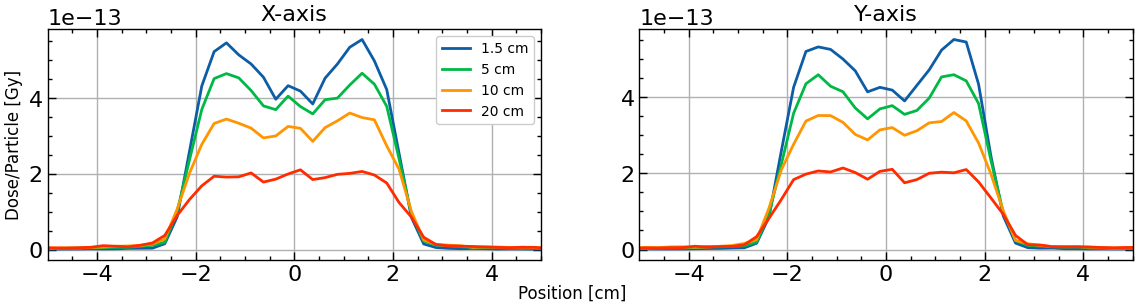

In [81]:
fig = plt.figure(figsize=(14,3))
plt.subplot(121)
plt.plot(d,cross_x_1.ravel(), label='1.5 cm')
plt.plot(d,cross_x_5.ravel(), label='5 cm')
plt.plot(d,cross_x_10.ravel(), label='10 cm')
plt.plot(d,cross_x_20.ravel(), label='20 cm')
plt.ylabel('Dose/Particle [Gy]', fontsize=12)
plt.xlim(-5,5)
plt.title('X-axis')
plt.grid()
plt.legend(fontsize=10, facecolor='white', framealpha=1, frameon=True, loc='upper right')
plt.subplot(122)
plt.plot(d,cross_y_1.ravel(), label='1.5 cm')
plt.plot(d,cross_y_5.ravel(), label='5 cm')
plt.plot(d,cross_y_10.ravel(), label='10 cm')
plt.plot(d,cross_y_20.ravel(), label='20 cm')
plt.title('Y-axis')
plt.grid()
plt.xlim(-5,5)
fig.suptitle(r'Position [cm]',x=0.5,y=0.03, ha='center', fontsize=12)
plt.savefig('images/p6.png', dpi=200)
plt.show()

In [82]:
dose_smooth = np.mean([rotate(dose_hist, ang) for ang in np.linspace(0, 360, 40)], axis=0)[mid_xy]
#dose_smooth = dose_hist[mid_xy]
#dose_smooth = ndimage.gaussian_filter(dose_smooth, sigma=1, order=0)

In [83]:
rad = binsx[1:] - np.diff(binsx)[0]/2
z = binsz[1:] - np.diff(binsz)[0]/2
zv, rv = np.meshgrid(z, rad)

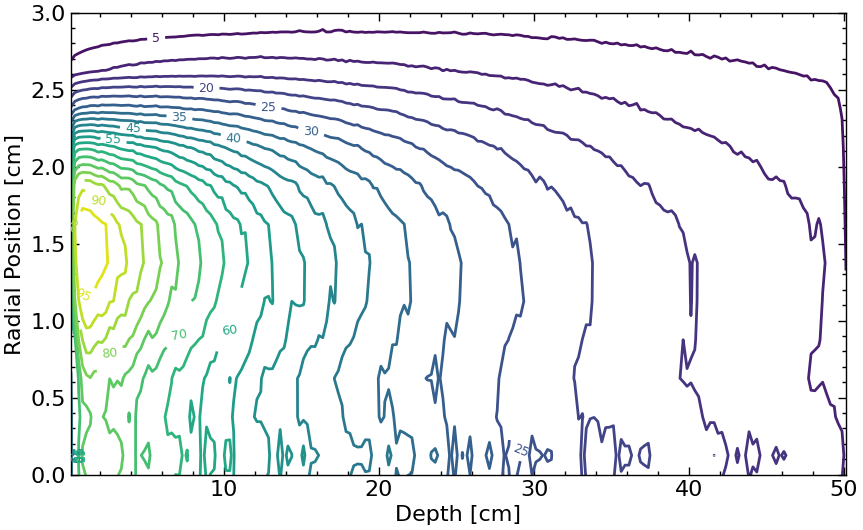

In [84]:
fig, ax = plt.subplots(figsize=(10,6))
CS = ax.contour(zv, rv, dose_smooth/dose_smooth.max() *100, levels=20)
ax.clabel(CS, CS.levels, inline=True, fontsize=9)
plt.xlabel('Depth [cm]')
plt.ylabel('Radial Position [cm]')
plt.ylim(0,3)
plt.savefig('images/isodose.png', dpi=200)
plt.show()

## Kerma Plot

$$dE_{trans}(x,y,z) = N_{\gamma}(x,y,z) A(E) \cdot E \cdot dF(E)$$
$$ E_{trans}(x,y,z) = N_{\gamma}(x,y,z) \int_E A(E) \cdot E f(E) dE$$

* $N_{\gamma}$ counted from monte carlo
* $A(E) = \mu_{tr}/\mu$, which depends on energy
* $F(E)$ is cdf and $f(E)$ is pdf of photon energy

Are $F(E)$ and $f(E)$ from initial photon spectrum? (not spacially dependent?) or do they depend on position (photon spectrum at given point in phanom)

In [85]:
# Compute integral factor
def compute_factor():
    d1 = np.array([2480,15000,27290,37590,46310,53760,60140,65680,70460,
                       74630,78290, 81510, 84330, 86860, 89090, 91060, 92790,
                       94330, 95670, 96840, 97850, 98710, 99420, 100000]) /100000
    d2 = np.arange(0.25, 6.25, 0.25)
    cdf_f = interp1d(d2,d1,kind='cubic')
    pdf_f = cdf_f._spline.derivative(nu=1)
    d1 = mutr_d/mu_d
    d2 = energy_d
    A_f = interp1d(d2,d1,kind='cubic')
    ees = np.linspace(0.25,6,1000)
    return sum(A_f(ees)*ees*pdf_f(ees).ravel()*np.diff(ees)[0])

In [91]:
kerma_pred_hist = tot_hist * compute_factor()

In [113]:
oc = xv**2 + yv**2 <= 1**2
oc_bool = np.tile(oc, (kerma_hist.shape[-1],1,1)).astype(int)
CF = len(oc_bool[0].ravel()) / np.sum(oc_bool[0])
kerma_center = np.mean(kerma_hist*oc_bool.T, axis=(0,1))* CF *f /N
kerma_pred_center = np.mean(kerma_pred_hist*oc_bool.T, axis=(0,1))* CF *f /N

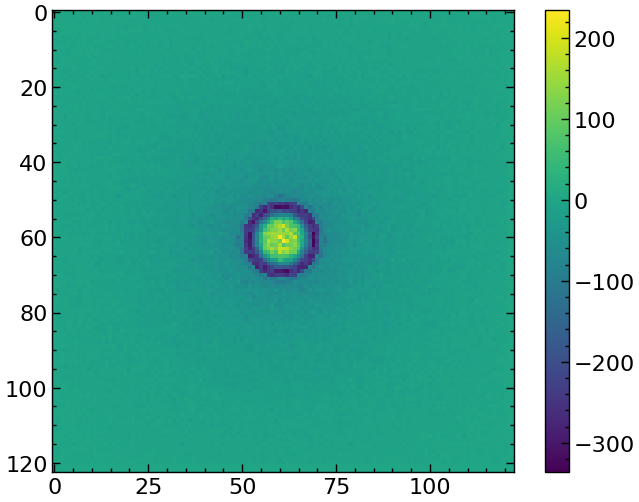

In [116]:
plt.imshow(kerma_hist[:,:,40] - kerma_pred_hist[:,:,40])
plt.colorbar()
plt.show()

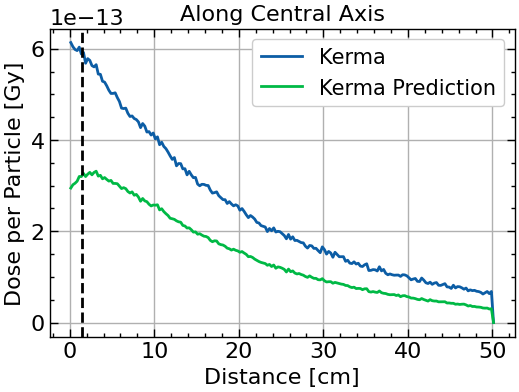

In [115]:
plt.figure(figsize=(6,4))
plt.subplot(111)
plt.title('Along Central Axis')
plt.plot(z, kerma_center, label='Kerma')
plt.plot(z, kerma_pred_center, label='Kerma Prediction')
plt.axvline(1.5, color='k', ls='--')
plt.grid()
plt.legend(fontsize=15, facecolor='white', framealpha=1, frameon=True, loc='upper right')
plt.xlabel('Distance [cm]')
plt.ylabel('Dose per Particle [Gy]')
plt.savefig('kerma_v_kermapred.png', dpi=200)
plt.show()

## Probability Stuff Plots

In [32]:
# Compute integral factor where f(E) is form incident beam


In [47]:
d1 = np.array([2480,15000,27290,37590,46310,53760,60140,65680,70460,
                       74630,78290, 81510, 84330, 86860, 89090, 91060, 92790,
                       94330, 95670, 96840, 97850, 98710, 99420, 100000]) /100000
d2 = np.arange(0.25, 6.25, 0.25)
A_f = interp1d(d2,d1,kind='cubic')
ees = np.linspace(0.25,6,1000)
E_distrid = np.diff(A_f(ees))/np.diff(ees)[0]
rrs = np.sqrt(2*np.log(6/ees))

Radius of maximum energy concentration:

In [48]:
Rmax = np.sqrt(2*np.log(6/ees[1:][np.argmax(ees[1:]*E_distrid)]))

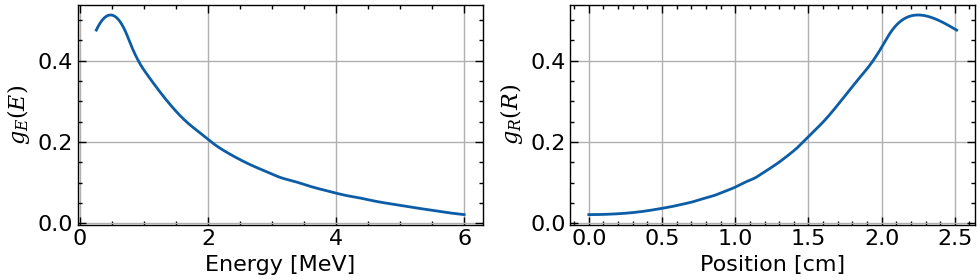

In [51]:
fig, ax = plt.subplots(1, 2, figsize=(10,3))
plt.subplot(121)
plt.plot(ees[1:], E_distrid)
plt.xlabel('Energy [MeV]')
plt.ylabel('$g_E(E)$')
plt.grid()
plt.subplot(122)
plt.plot(rrs[1:], E_distrid)
plt.xlabel('Position [cm]')
plt.ylabel('$g_R(R)$')
plt.grid()
fig.tight_layout()
plt.savefig('images/energy_beam_pdf.png', dpi=200)
plt.show()

In [33]:
fac = compute_factor()
kerma_tot_hist = tot_hist * fac
oc = xv**2 + yv**2 <= 1**2
oc_bool = np.tile(oc, (kerma_tot_hist.shape[-1],1,1)).astype(int)
CF = len(oc_bool[0].ravel()) / np.sum(oc_bool[0])
kerma_tot_center = np.mean(kerma_tot_hist*oc_bool.T, axis=(0,1))* CF *f /N

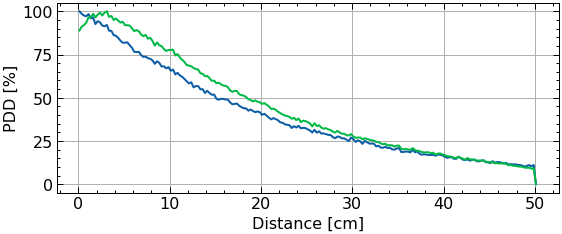

In [34]:
plt.figure(figsize=(9,3.5))
plt.subplot(111)
plt.plot(z, kerma_center/max(kerma_center) * 100, label='Dose')
plt.plot(z, kerma_tot_center/max(kerma_tot_center) * 100, label='Dose')
plt.grid()
plt.xlabel('Distance [cm]')
plt.ylabel('PDD [%]')
plt.show()

In [ ]:
value, bins = np.histogram(r.comptonenergies, Ebins, weights=r.comptonthetaes)
total, bins = np.histogram(r.comptonenergies, Ebins)
ce = value/total
Ep = bins[:-1] + np.diff(bins)/2

In [ ]:
plt.hist(r.comptonthetas)

In [ ]:
plt.scatter(Ep, ce)
plt.axhline(np.pi/4)

In [ ]:
plt.hist(r.E_e, bins=100)
plt.semilogy()
plt.show()

In [ ]:
plt.hist2d(r.Ang_e[0], r.Ang_e[1], bins=20)
plt.colorbar()
plt.show()

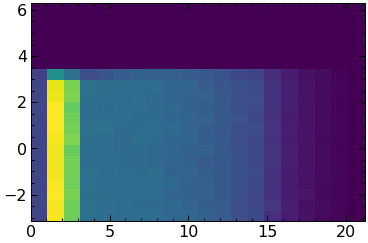

In [48]:
plt.hist2d(np.sqrt(r.X_e[0]**2 + r.X_e[1]**2), r.Ang_e[0], bins=20)
plt.show()

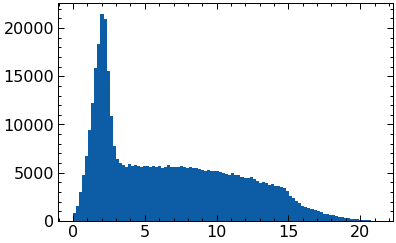

In [49]:
plt.hist(np.sqrt(r.X_e[0]**2 + r.X_e[1]**2), bins=100)
plt.show()

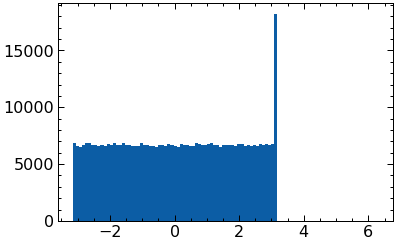

In [50]:
plt.hist(r.Ang_e[0], bins=100)
plt.show()

In [31]:
np.mean(a[15:-15]*1e11)

0.45542209582611287

Check compton energy transfer is correct

In [16]:
E, alpha, T, theta = smp.symbols(r'E \alpha T \theta', real=True, positive=True)
T_expr = E*alpha*(1-smp.cos(theta))/(1+alpha*(1-smp.cos(theta)))
theta_expr = smp.solve(T-T_expr, theta)[1]
dsdo_expr = smp.Rational(1,2)*(1+smp.cos(theta)**2)/(1+alpha*(1-smp.cos(theta)))**2 * \
            ( 1 + alpha**2 * (1-smp.cos(theta))**2 / ((1+smp.cos(theta)**2)*(1+alpha*(1-smp.cos(theta)))))
dsdT = 2*smp.pi*smp.sin(theta) * dsdo_expr / smp.diff(T_expr, theta)
dsdT = dsdT.subs(theta, theta_expr).simplify()
Tmin = 0 
Tmax = 2*E*alpha/(1+2*alpha)
sigma_check = smp.integrate(dsdT, (T, Tmin, Tmax)).expand().simplify().simplify()
pdf = dsdT / sigma_check
avgT = smp.integrate(pdf*(T/E), (T, Tmin, Tmax)).simplify().simplify()
avgT_f = smp.lambdify(alpha, avgT)
energy_arr = np.linspace(0.01, 6, 1000)
avgT_arr = avgT_f(energy_arr/0.511)

In [17]:
pdf_theta_f = smp.lambdify([theta, alpha], 2*smp.pi*smp.sin(theta) *dsdo_expr/sigma_check)

In [18]:
ratios, bins = np.histogram(r.comptonenergies, Ebins, weights=r.comptonratios)
total, bins = np.histogram(r.comptonenergies, Ebins)
T = ratios/total
Ep = bins[:-1] + np.diff(bins)/2

/Users/lukepolson/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:3: RuntimeWarning: invalid value encountered in true_divide
  This is separate from the ipykernel package so we can avoid doing imports until


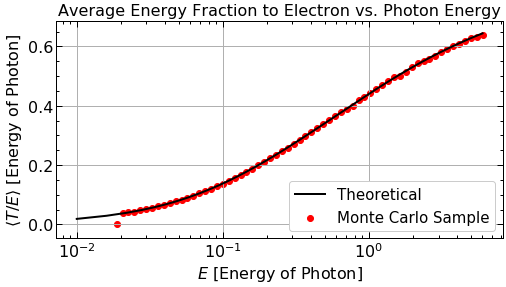

In [19]:
plt.figure(figsize=(8,4))
plt.scatter(Ep, T, color='r', label='Monte Carlo Sample')
plt.plot(energy_arr, avgT_arr, color='k', label='Theoretical')
plt.title('Average Energy Fraction to Electron vs. Photon Energy')
plt.xlabel('$E$ [Energy of Photon]')
plt.ylabel(r'$\left<T/E\right>$ [Energy of Photon]')
plt.grid()
plt.legend(fontsize=15, facecolor='white', framealpha=1, frameon=True, loc='lower right')
plt.semilogx()
plt.show()

In [20]:
r.iterate()

True

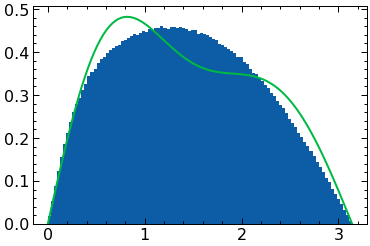

In [21]:
thetas = np.linspace(0, np.pi, 100)
ppddff = pdf_theta_f(thetas, 0.1/0.511)
plt.hist(r.comptonthetas, bins=100, density=True)
plt.plot(thetas, ppddff)
plt.show()